In [1]:
import re
import pandas as pd
import numpy as np
from numpy import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
%matplotlib inline

In [2]:
df = pd.read_excel('hatespeech_text.xlsx', header = None)
df.rename(columns={0:'tweets', 1:'labels'}, inplace=True)
print(df.head(10))


                                              tweets   labels
0  RT @Papapishu: Man it would fucking rule if we...  hateful
1  It is time to draw close to Him &#128591;&#127...   normal
2  if you notice me start to act different or dis...   normal
3  Forget unfollowers, I believe in growing. 7 ne...   normal
4  RT @Vitiligoprince: Hate Being sexually Frustr...  hateful
5  Topped the group in TGP Disc Jam Season 2! Ont...   normal
6  That daily baby aspirin for your #heart just m...   normal
7  I liked a @YouTube video from @mattshea https:...   normal
8  RT @LestuhGang_: If your fucking up &amp; your...  hateful
9  @Move_Fwd give up. You've lost. You will not c...   normal


In [3]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['labels']=le.fit_transform(df['labels'])
df.head()

,tweets,labels
0,RT @Papapishu: Man it would fucking rule if we...,0
1,It is time to draw close to Him &#128591;&#127...,1
2,if you notice me start to act different or dis...,1
3,"Forget unfollowers, I believe in growing. 7 ne...",1
4,RT @Vitiligoprince: Hate Being sexually Frustr...,0


In [4]:
de=pd.read_pickle("./emoji_tweets.pkl")
emoji = pd.DataFrame.from_dict(de)
emoji.head()


,tweets,labels
0,lmfaoo 😭 😭 😭 😭 😭,0
1,i hate this feeling 😢,0
2,can't believe i just went out in this cold to ...,0
3,"i need a new trap house, so if you really fuck...",0
4,<user> so very sorry for your loss. 💔,0


In [5]:
data = pd.concat([df,emoji])
data.head()
data.tweets=data.tweets.astype(str)

In [6]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')
STOPWORDS.append("rt")
STOPWORDS.append("<user>")
STOPWORDS.append("<url>")
def clean_text():
    data["tweets"] = data["tweets"].apply(lambda x: x.lower())
    data["tweets"] = [re.sub('(@[^\s]+)|(#[^\s]+)', '', tweet) for tweet in data["tweets"]]
    data["tweets"] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) for tweet in data["tweets"]]
    data["tweets"] = data["tweets"].str.split(' ').apply(lambda tweet: ' '.join(k for k in tweet if k not in STOPWORDS))
    data["tweets"] = data["tweets"].str.replace(' +', ' ', case=False)
    data["tweets"] = data["tweets"].str.strip()
    data["tweets"].replace('', np.nan, inplace=True)
    df.dropna(subset=["tweets"], inplace=True)
      
clean_text()
    
print(data.head(10))
print(data.tail(10))
len(df)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2536\3681592589.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data["tweets"] = data["tweets"].str.replace(' +', ' ', case=False)


                                              tweets  labels
0    man would fucking rule party perpetual warfare.       0
1      time draw close & father, draw near always ❤️       1
2  notice start act different distant.. bc peeped...       1
3  forget unfollowers, believe growing. 7 new fol...       1
4  hate sexually frustrated like wanna fuck ion w...       0
5  topped group tgp disc jam season 2! onto semi-...       1
6     daily baby aspirin might preventing colon too.       1
7  liked video blue army coming! - ancient warfare 2       1
8  fucking &amp; homies dont tell fucking up, ain...       0
9  give up. lost. convince one iota read conspira...       1
                                                  tweets  labels
13190  clear message. use helmet save life 👇 \n\n<use...       1
13191                         funny 😆 wish could get one       1
13192                        show respect, get respect ☝       1
13193                              waahh im happy you! 💖       1
1319

85966

In [7]:
import emoji
def emoticon(sentence):
    words=word_tokenize(sentence)
    stem_sentence=[]
    for word in words:
        if emoji.demojize(word)== None:
            stem_sentence.append(word)
            stem_sentence.append(" ")
        else:
            word= emoji.demojize(word)
            word = word.replace(":"," ")
            word = word.replace("_"," ")
            stem_sentence.append(word)
            stem_sentence.append(" ")
    return "".join(stem_sentence)
    
training_size = 1000000        
sentences = data.tweets.astype(str)
sentences = sentences[:training_size].apply(emoticon)
sentences.head()
sentences.tail()

13195    love waking skinny ahaha wish lasted day  grin...
13196    magnificent pair tits  smiling face with heart...
13197    soon mamsh  face blowing a kiss  god give best...
13198              trust u  smiling face with sunglasses  
13199         aww thanks  beaming face with smiling eyes  
Name: tweets, dtype: object

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

def stemSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    words=word_tokenize(sentence)
    stem_sentence=[]
    for word in words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
training_size = 1000000
sentences = sentences[:training_size].apply(stemSentence)
sentences.head()
sentences.tail()

13195    love waking skinny ahaha wish lasted day grinn...
13196    magnificent pair tit smiling face with heart-e...
13197    soon mamsh face blowing a kiss god give best a...
13198                  trust u smiling face with sunglass 
13199            aww thanks beaming face with smiling eye 
Name: tweets, dtype: object

In [9]:
from sklearn.model_selection import train_test_split

# Data splitting
X = sentences
y = data["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

print ('Total   tweet count:', len(data))
print ('Normal  tweet count:', len(data[data.labels == 1]))
print ('Hateful tweet count:', len(data[data.labels == 0]), '\n')
print ('Total tweet count in training sampple:', len(X_train))
print ('Total tweet count in test sample:    ', len(X_test))
print ('Normal  tweet count in X_train:', X_train[y_train == 1].count())
print ('Hateful tweet count in X_train:', X_train[y_train == 0].count())
print ('Normal  tweet count in X_test: ', X_test[y_test == 1].count())
print ('Hateful tweet count in X_test: ', X_test[y_test == 0].count())

Total   tweet count: 99166
Normal  tweet count: 60450
Hateful tweet count: 38716 

Total tweet count in training sampple: 79332
Total tweet count in test sample:     19834
Normal  tweet count in X_train: 48376
Hateful tweet count in X_train: 30956
Normal  tweet count in X_test:  12074
Hateful tweet count in X_test:  7760


In [10]:
import pickle

tfidftrans = TfidfVectorizer()
X_train = tfidftrans.fit_transform(X_train)
print(X_train.shape)
pickle.dump(tfidftrans, open("tfidf.pickle", "wb"))

(79332, 52947)


In [11]:
X_test = tfidftrans.transform(X_test)
print(X_test.shape)

(19834, 52947)


In [12]:
def training(clf,x_train,Y_train):
    clf.fit(x_train,Y_train)
def predict(clf,X_test):
    return clf.predict(X_test)
dict={}


In [13]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,5):
    knn = KNeighborsClassifier(n_neighbors=i)
    training(knn,X_train,y_train)
    pred = predict(knn,X_test)
    print('k = ',i)
    print(accuracy_score(y_test,pred,normalize=True))
    print(classification_report(y_test, pred))
    print(confusion_matrix(y_test,pred))
    dict[knn,i]=accuracy_score(y_test,pred,normalize=True)

k =  1
0.4948068972471514
              precision    recall  f1-score   support

           0       0.43      0.96      0.60      7760
           1       0.89      0.19      0.32     12074

    accuracy                           0.49     19834
   macro avg       0.66      0.58      0.46     19834
weighted avg       0.71      0.49      0.43     19834

[[7479  281]
 [9739 2335]]
k =  2
0.4708077039427246
              precision    recall  f1-score   support

           0       0.42      0.99      0.59      7760
           1       0.95      0.14      0.24     12074

    accuracy                           0.47     19834
   macro avg       0.69      0.56      0.42     19834
weighted avg       0.75      0.47      0.38     19834

[[ 7675    85]
 [10411  1663]]
k =  3
0.787435716446506
              precision    recall  f1-score   support

           0       0.90      0.51      0.65      7760
           1       0.76      0.96      0.85     12074

    accuracy                           0.79    

In [14]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
training(dt,X_train,y_train)
pred = predict(dt,X_test)
print(accuracy_score(y_test,pred,normalize=True))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))
dict[dt]=accuracy_score(y_test,pred,normalize=True)

0.9153978017545629
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7760
           1       0.93      0.93      0.93     12074

    accuracy                           0.92     19834
   macro avg       0.91      0.91      0.91     19834
weighted avg       0.92      0.92      0.92     19834

[[ 6945   815]
 [  863 11211]]


In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
training(lr,X_train,y_train)
pred = predict(lr,X_test)
print(accuracy_score(y_test,pred,normalize=True))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))
dict[lr]=accuracy_score(y_test,pred,normalize=True)

0.9364223051326006
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      7760
           1       0.93      0.97      0.95     12074

    accuracy                           0.94     19834
   macro avg       0.94      0.93      0.93     19834
weighted avg       0.94      0.94      0.94     19834

[[ 6860   900]
 [  361 11713]]


In [16]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha =0.2)
training(mnb,X_train,y_train)
pred = predict(mnb,X_test)
print(accuracy_score(y_test,pred,normalize=True))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test,pred))
dict[mnb]=accuracy_score(y_test,pred,normalize=True)

0.8866088534839165
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      7760
           1       0.89      0.92      0.91     12074

    accuracy                           0.89     19834
   macro avg       0.88      0.88      0.88     19834
weighted avg       0.89      0.89      0.89     19834

[[ 6428  1332]
 [  917 11157]]


C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\stride_tricks.py:342: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array, copy=False, subok=subok)


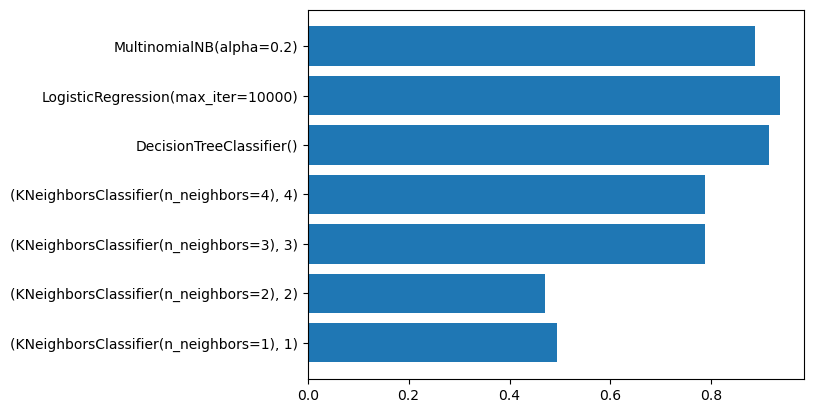

In [17]:
import matplotlib.pyplot as plt
names = list(dict.keys())
values = list(dict.values())
plt.barh(range(len(dict)), values, tick_label=names)
plt.show()

In [10]:
vocab_size = 10000
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post' 
oov_tok = "<OOV>"
training_size = 100000
total_size = 1000000

In [11]:
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(X,y, test_size = 0.2)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
from tensorflow.keras.layers import LSTM
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(9)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)

In [15]:
history1 = model.fit(training_padded, training_labels, 
                    epochs=20, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=1,callbacks=[callback])

Epoch 1/20
2480/2480 [==============================] - 153s 59ms/step - loss: 0.2757 - accuracy: 0.9116 - val_loss: 0.1850 - val_accuracy: 0.9410
Epoch 2/20
2480/2480 [==============================] - 152s 61ms/step - loss: 0.1862 - accuracy: 0.9474 - val_loss: 0.1877 - val_accuracy: 0.9404
Epoch 3/20
2480/2480 [==============================] - 154s 62ms/step - loss: 0.1633 - accuracy: 0.9514 - val_loss: 0.1927 - val_accuracy: 0.9388
Epoch 4/20
2480/2480 [==============================] - 121s 49ms/step - loss: 0.1497 - accuracy: 0.9558 - val_loss: 0.2118 - val_accuracy: 0.9383
Epoch 5/20
2480/2480 [==============================] - 113s 46ms/step - loss: 0.1352 - accuracy: 0.9595 - val_loss: 0.2199 - val_accuracy: 0.9346
Epoch 6/20
2480/2480 [==============================] - 115s 46ms/step - loss: 0.1233 - accuracy: 0.9632 - val_loss: 0.2399 - val_accuracy: 0.9327
Epoch 7/20
2480/2480 [==============================] - 116s 47ms/step - loss: 0.1116 - accuracy: 0.9670 - val_loss: 0

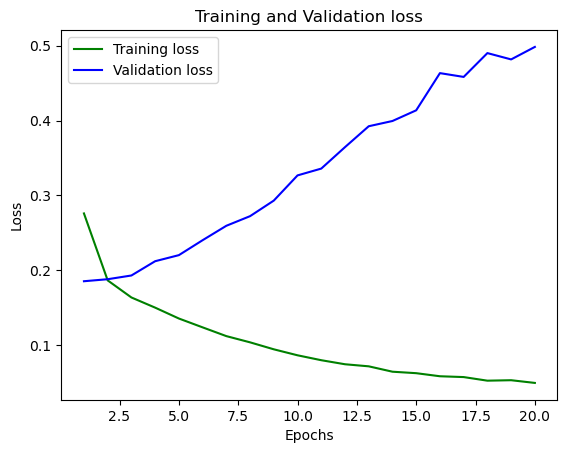

In [21]:
loss_train1 = history1.history['loss']
loss_val1 = history1.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train1, 'g', label='Training loss')
plt.plot(epochs, loss_val1, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

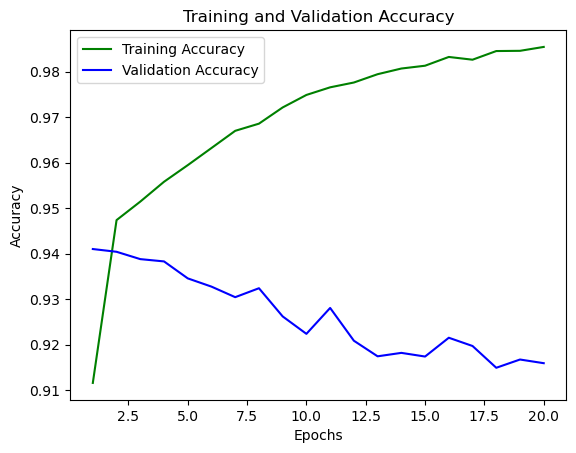

In [32]:
acc_train1 = history1.history['accuracy']
acc_val1 = history1.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, acc_train1, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val1, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
from tensorflow import keras
model.save('lstm.h5')


In [28]:
lstm_model = tf.keras.models.load_model('lstm.h5')

In [10]:
import numpy as np
from transformers import TFBertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load preprocessed sentences and target labels
sentences = X.tolist()  # list of preprocessed sentences
labels = y.tolist()  # list of target labels

# Split data into training and validation sets
split_index = int(len(sentences) * 0.8)
train_sentences = sentences[:split_index]
train_labels = labels[:split_index]
val_sentences = sentences[split_index:]
val_labels = labels[split_index:]

# Convert labels to numerical values
num_classes = 2  # or the number of classes in your task
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
# train_labels = np.eye(num_classes)[train_labels]
# val_labels = np.eye(num_classes)[val_labels]

In [11]:
import tensorflow as tf
from transformers import TFBertModel, TFBertTokenizer

# Load pre-trained BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = TFBertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize input sentences
train_encodings = tokenizer(train_sentences[:10000], truncation=True, padding="max_length", max_length=128)
val_encodings = tokenizer(val_sentences[:10000], truncation=True, padding="max_length", max_length=128)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
# Infer with BERT
bert_output = bert_model.predict(train_encodings)

313/313 [==============================] - 990s 3s/step


In [26]:
# Build LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Train LSTM model with BERT output
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history = lstm_model.fit(
    bert_output.last_hidden_state[:8000], 
    train_labels[:8000], 
    epochs=20, 
    validation_data=(bert_output.last_hidden_state[6000:], train_labels[6000:10000])
)

Epoch 1/20
250/250 [==============================] - 34s 130ms/step - loss: 0.3203 - accuracy: 0.8699 - val_loss: 0.2993 - val_accuracy: 0.8815
Epoch 2/20
250/250 [==============================] - 27s 107ms/step - loss: 0.2721 - accuracy: 0.8929 - val_loss: 0.3017 - val_accuracy: 0.8702
Epoch 3/20
250/250 [==============================] - 30s 122ms/step - loss: 0.2504 - accuracy: 0.9016 - val_loss: 0.2440 - val_accuracy: 0.9080
Epoch 4/20
250/250 [==============================] - 28s 112ms/step - loss: 0.2266 - accuracy: 0.9143 - val_loss: 0.2436 - val_accuracy: 0.9055
Epoch 5/20
250/250 [==============================] - 27s 110ms/step - loss: 0.2001 - accuracy: 0.9283 - val_loss: 0.2245 - val_accuracy: 0.9162
Epoch 6/20
250/250 [==============================] - 26s 105ms/step - loss: 0.1795 - accuracy: 0.9367 - val_loss: 0.2140 - val_accuracy: 0.9197
Epoch 7/20
250/250 [==============================] - 26s 103ms/step - loss: 0.1596 - accuracy: 0.9421 - val_loss: 0.2103 - val_ac

In [23]:
len(bert_output[0][0])

128

In [34]:
lstm_model.save('new_lstm.h5')

In [1]:
import tensorflow as tf
new_lstm = tf.keras.models.load_model('new_lstm.h5')

In [14]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [13]:
new_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                213248    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 217,473
Trainable params: 217,473
Non-trainable params: 0
_________________________________________________________________


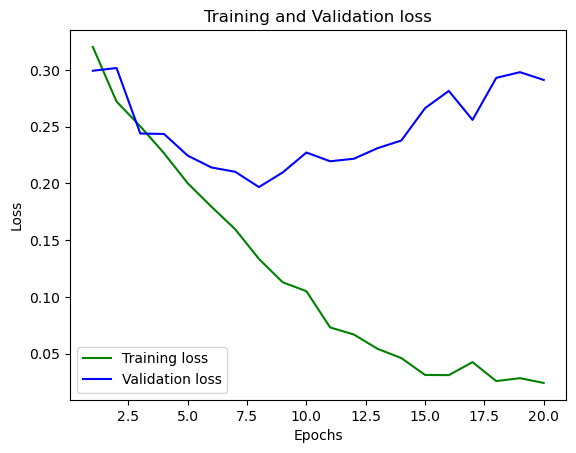

In [30]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

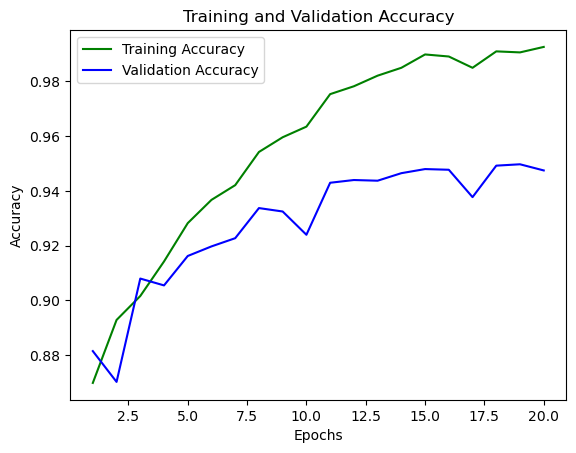

In [31]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [2]:
import tensorflow as tf
from transformers import TFBertModel, TFBertTokenizer

# Load pre-trained BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = TFBertTokenizer.from_pretrained('bert-base-uncased')
def result(sentence):
    s = sentence
    def clean_text(sentence):
        sentence = sentence.lower()
        sentence = re.sub('(@[^\s]+)|(#[^\s]+)', '', sentence)
        sentence = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',sentence)
        sentence = re.sub(r'[ ]+', ' ', sentence)
        words = word_tokenize(sentence)
        words = [word for word in words if not word in STOPWORDS]
        clean_sentence=[]
        for word in words:
            clean_sentence.append(" ")
        return "".join(clean_sentence)
    clean_text(sentence)
    sentence =emoticon(sentence)
    sentence = [stemSentence(sentence)]
    #print(sentence)
    
    encoding =  tokenizer(sentence, truncation=True, padding="max_length", max_length=128)
    bert_output = bert_model.predict(encoding)
    print(s)
    print("Probability of sentence being normal ->")
    print(new_lstm.predict(bert_output['last_hidden_state']))
    print("Hateful or normal->")
    print('normal' if new_lstm.predict(bert_output['last_hidden_state'])>0.5 else 'hateful')
    

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from commentscraper import scrape_comments
url = input('Enter video link = ')
sentences = scrape_comments(url)
#print(comments)
for sentence in sentences:
    result(sentence)